In [1]:
!pip install selenium
!pip install webdriver-manager
!pip install pandas
!pip install prophet
!pip install matplotlib

!pip install cython
!pip install pystan
!pip install plotly
!pip install sklearn

!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

import matplotlib.font_manager as fm
import numpy as np
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
ERROR: pip's dependency resolver does not currently take into a

In [2]:
import pandas as pd

import sys
import time
from webdriver_manager.chrome import ChromeDriverManager
from urllib.request import *
from prophet import Prophet
from bs4 import *
import matplotlib.pyplot as plt

from google.colab import drive
import csv
import matplotlib.pyplot as plt
import os

drive.mount('./gdrive', force_remount = True)

path =  './gdrive/MyDrive/dldata/'
file_list=os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('csv')]


Mounted at ./gdrive


In [3]:
#데이터 과일종류 > 연도순 정리
path =  './gdrive/MyDrive/dldata/'
file_list=os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('csv')]

fruit={}
for i in file_list_py:
  f = open(path+i,'r',encoding='cp949')
  data = csv.reader(f,delimiter=',')
  next(data)

  for row in data:  
    if row[1] != '0':
      if row[-1] =='기타':
        row[-1] = row[6]  
      if row[-1] not in fruit:
        fruit[row[-1]] = {}
      date=str(row[0][0:6])
      if date not in fruit[row[-1]]:
        fruit[row[-1]][date] = {'sum' : float(row[3])/float(row[1])*float(row[4]), 'count':int(row[4])}
      else:
        fruit[row[-1]][date]['sum'] += float(row[3])/float(row[1])*float(row[4])
        fruit[row[-1]][date]['count'] += int(row[4])
for fruit_name in fruit:
  for date in fruit[fruit_name]:
    fruit[fruit_name][date] = fruit[fruit_name][date].get('sum')/fruit[fruit_name][date].get('count')


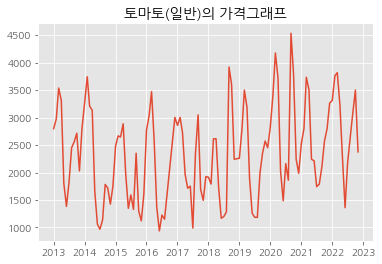

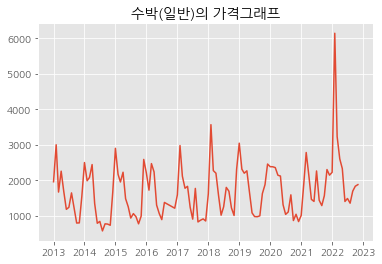

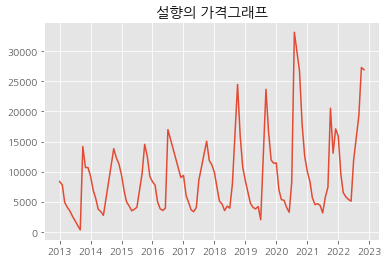

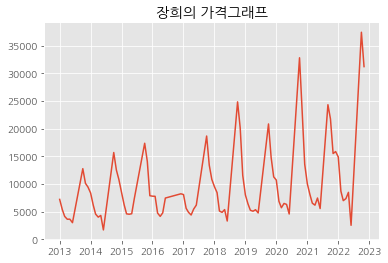

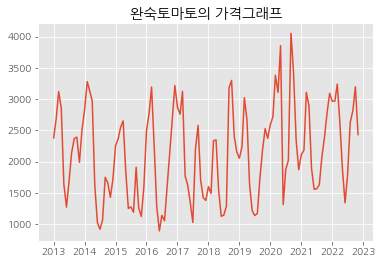

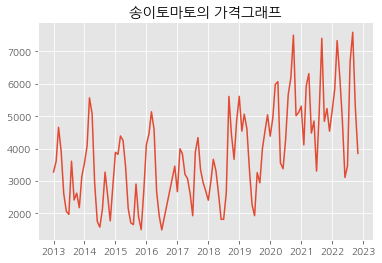

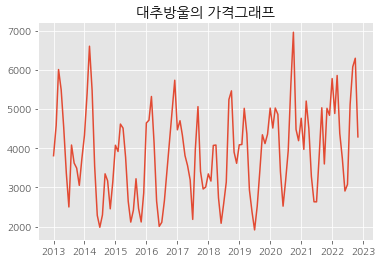

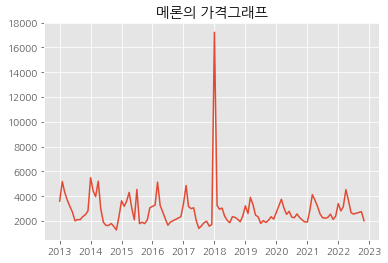

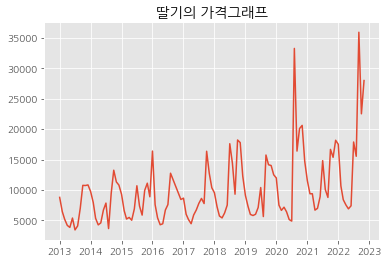

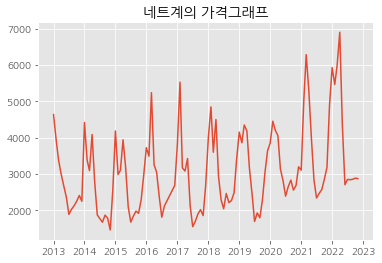

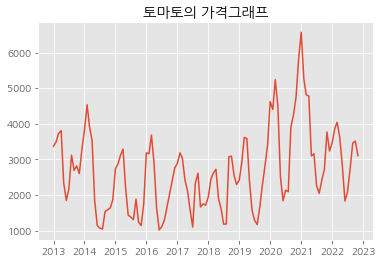

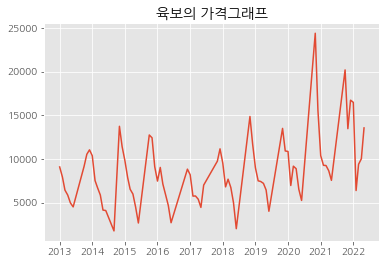

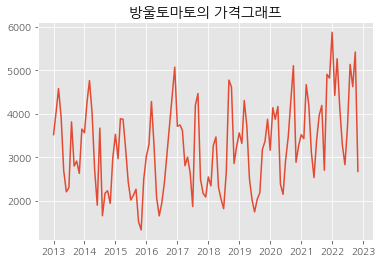

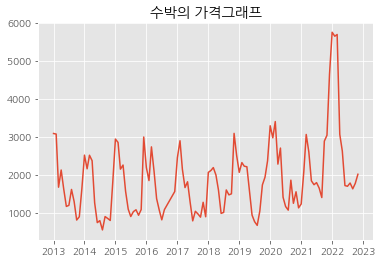

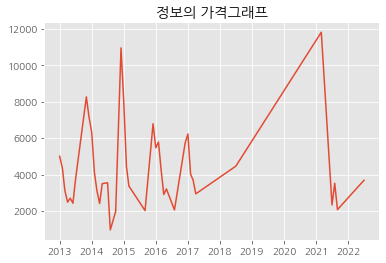

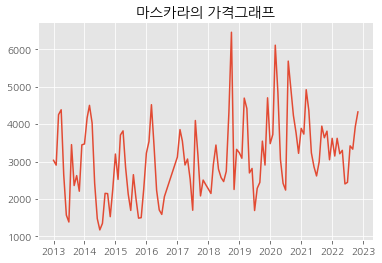

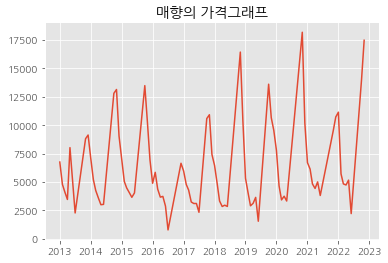

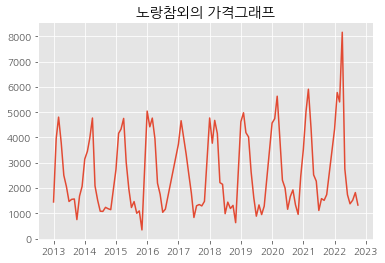

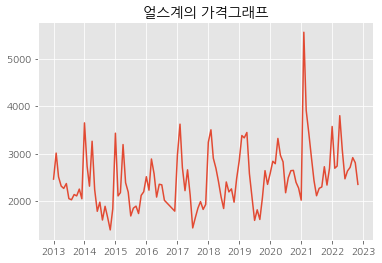

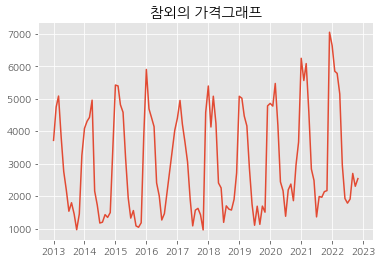

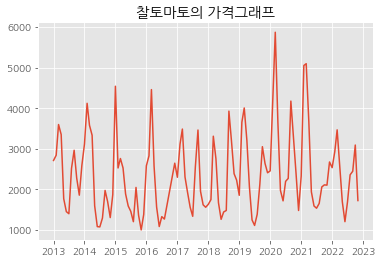

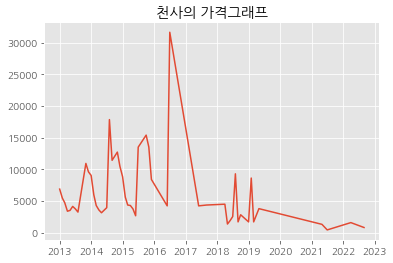

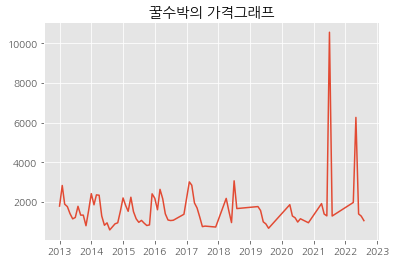

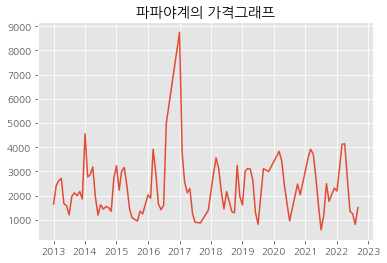

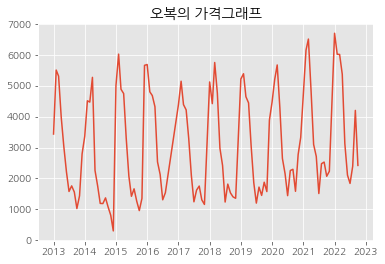

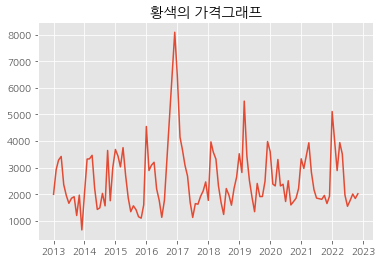

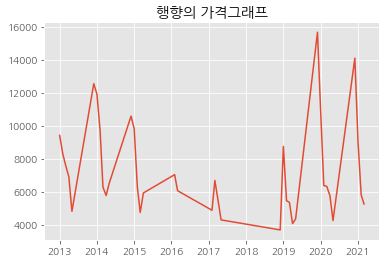

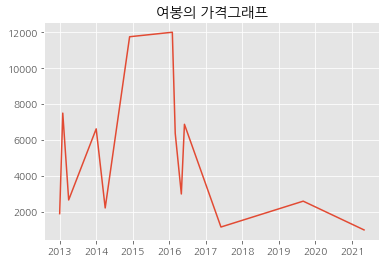

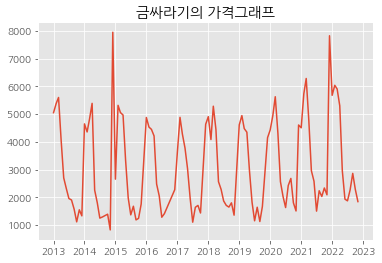

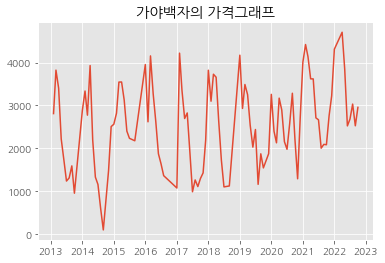

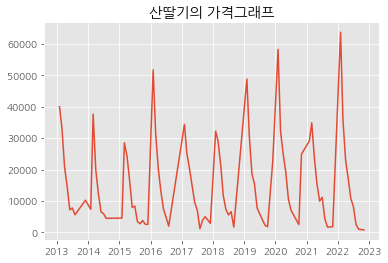

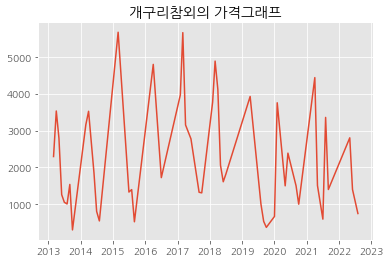

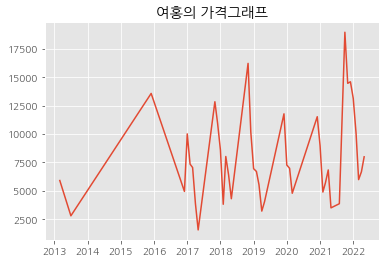

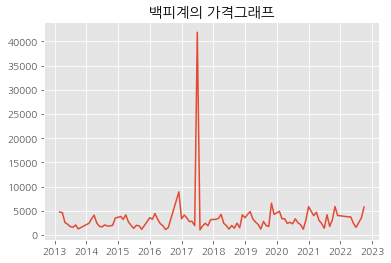

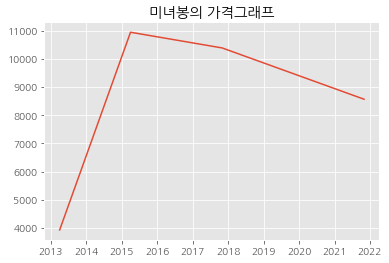

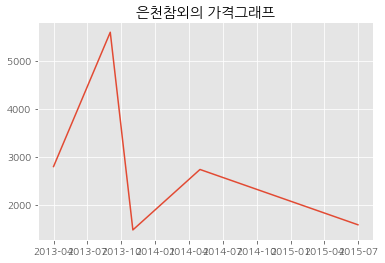

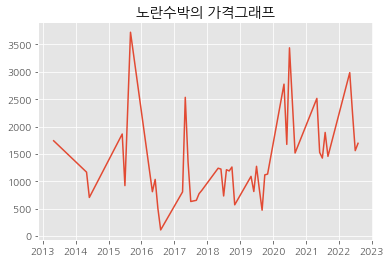

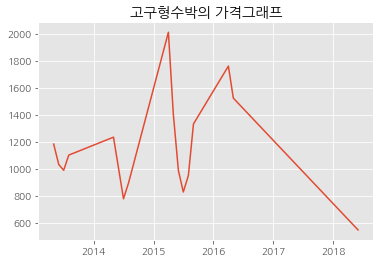

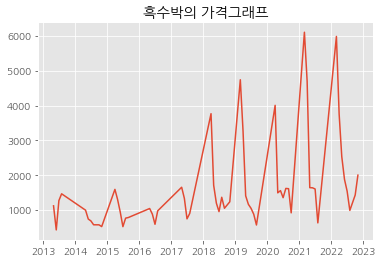

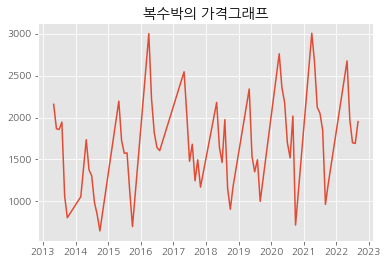

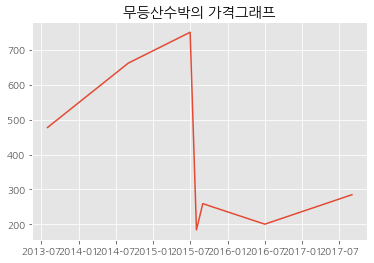

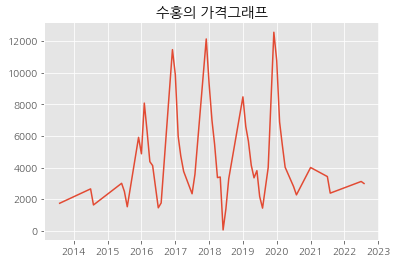

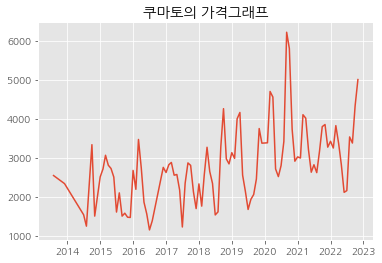

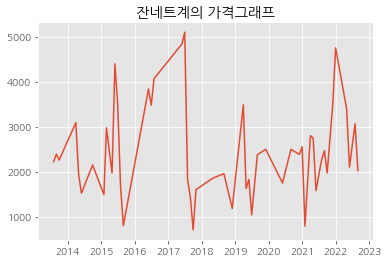

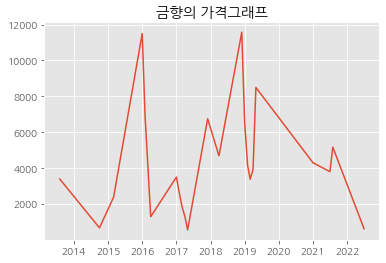

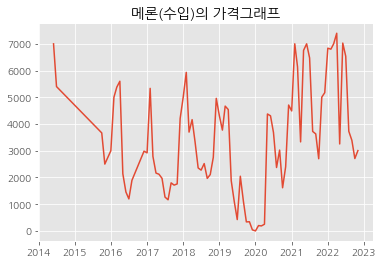

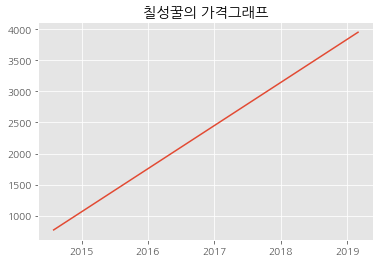

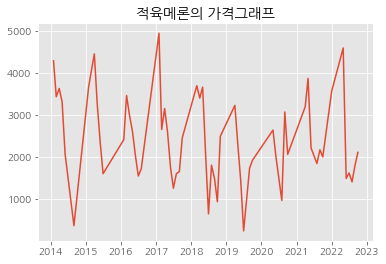

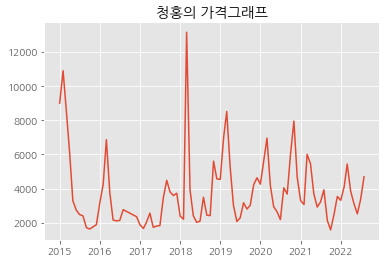

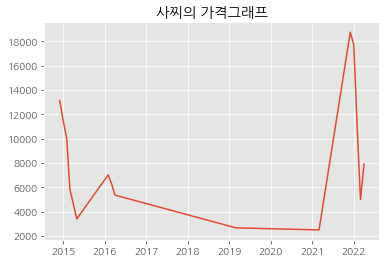

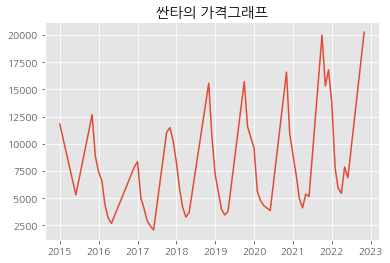

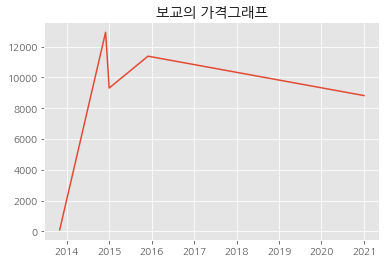

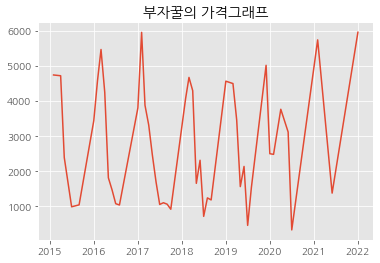

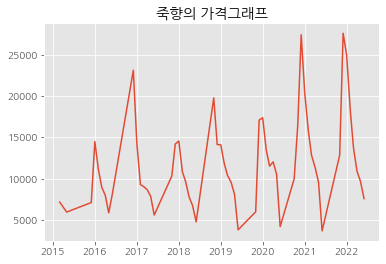

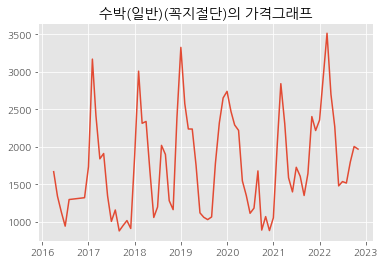

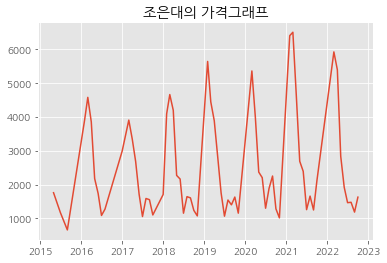

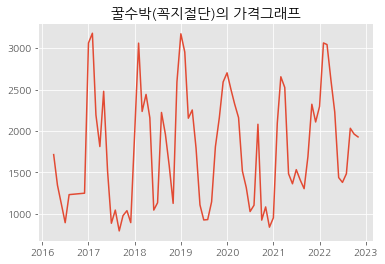

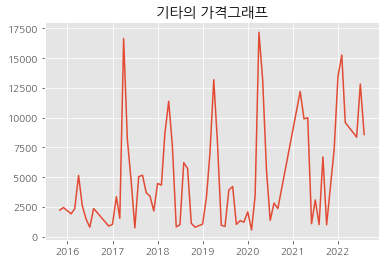

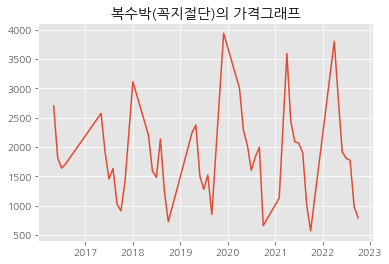

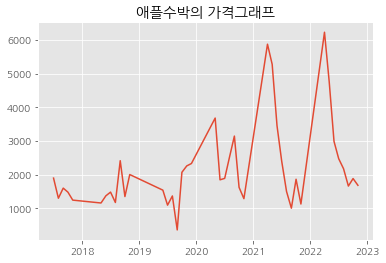

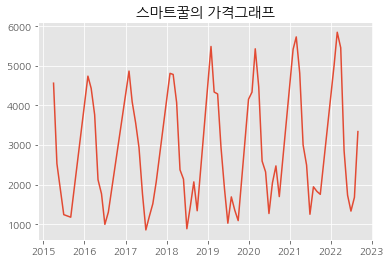

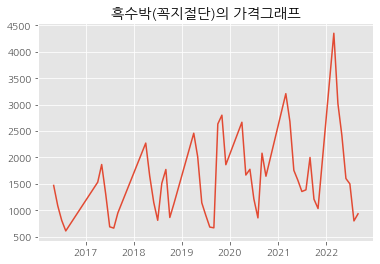

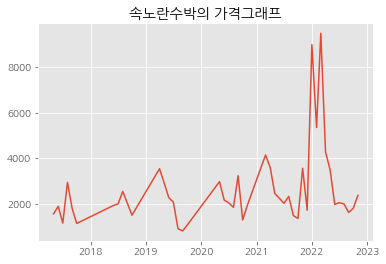

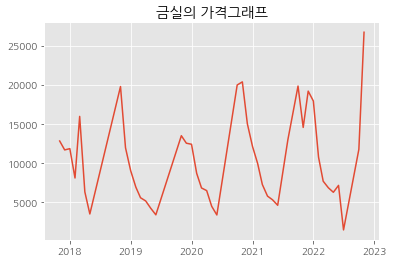

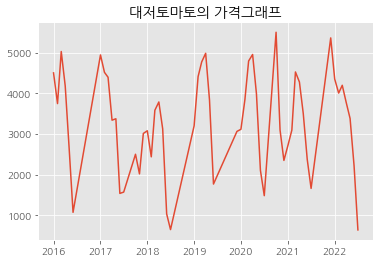

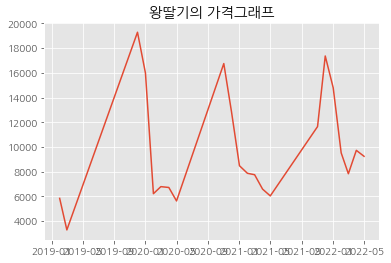

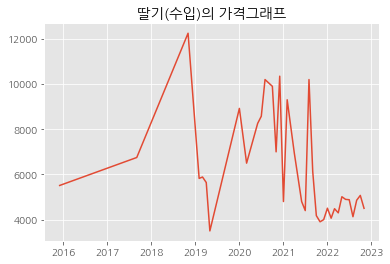

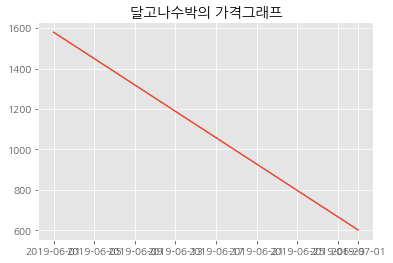

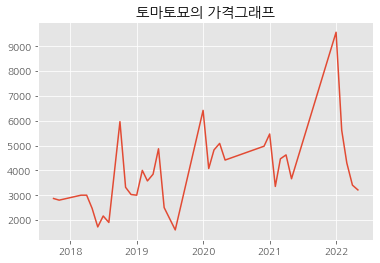

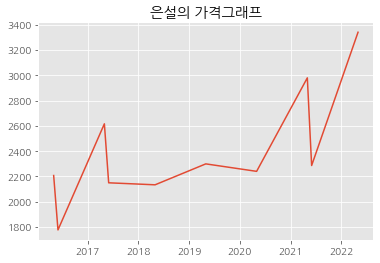

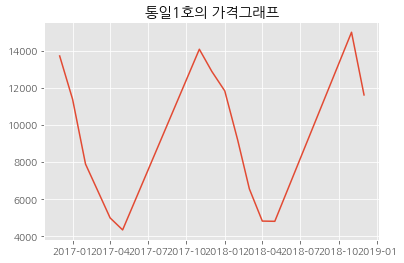

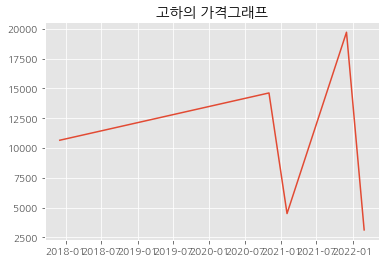

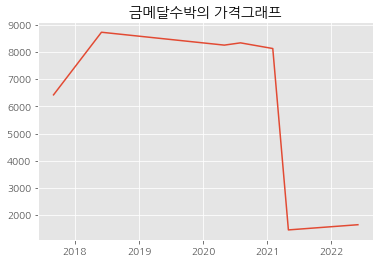

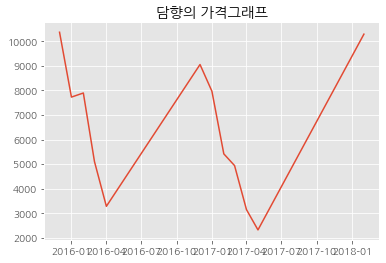

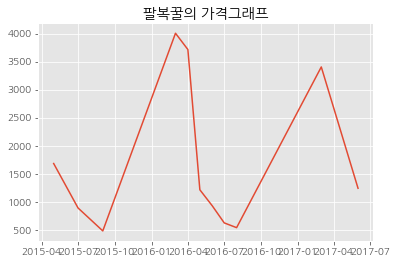

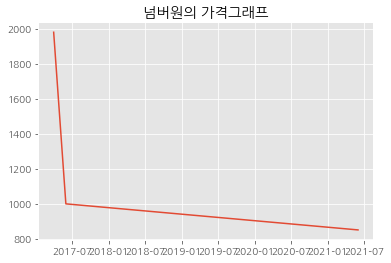

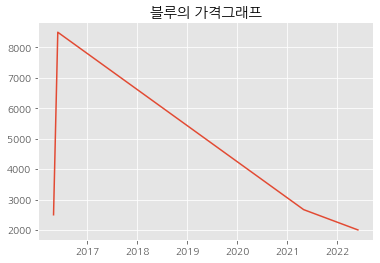

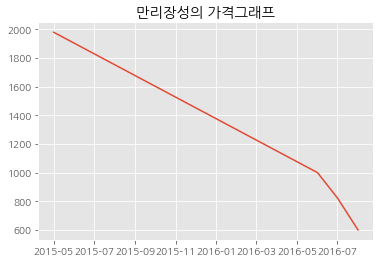

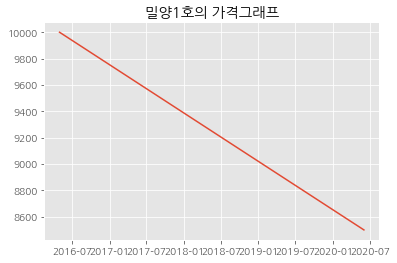

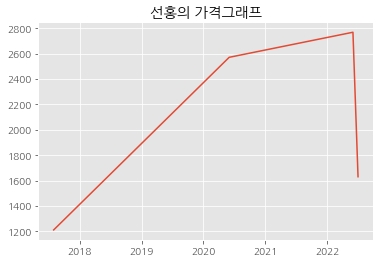

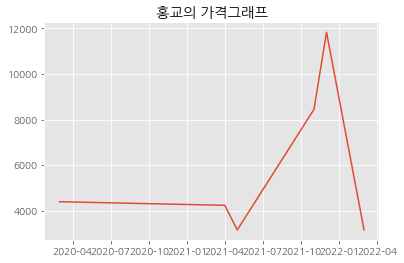

In [57]:
month = '03' # 예측에 쓰일 month
y = []
x = []
test_year = ['2022','2021','2020','2019','2018']

for fruit_name in fruit:
  test_count=0
  if len(fruit[fruit_name].values()) != 1:
    fruit_pd = pd.DataFrame({'ID': fruit_name,
                            'Date':fruit[fruit_name].keys(),
                            'Price':fruit[fruit_name].values()})
    fruit_pd['Date'] = pd.to_datetime(fruit_pd['Date'] + '01')
    fruit_pd = fruit_pd.sort_values(by='Date')

    train = fruit_pd[::]

    
    for i in test_year:
      if pd.to_datetime(i+month+'01') in list(train['Date']):
        test_count+=1
    if test_count==5:
      temp=[]
      for i in range(len(test_year)-1):
        last_year = fruit[train['ID'][0]][test_year[i+1]+month]
        this_year = fruit[train['ID'][0]][test_year[i]+month]
        temp.append(round((this_year-last_year)/last_year * 100,2))
      y.append(temp)
      x.append(fruit_name)

#가격 그래프
    plt.style.use('ggplot')
    font_name = fm.FontProperties(fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', size=10).get_name()
    plt.rc('font', family=font_name)
    plt.rc('axes', unicode_minus=False)
    plt.plot(train['Date'], train['Price'])
    plt.title("%s의 가격그래프" %train['ID'][0])
    plt.show()



In [58]:
#예측
predict_times=[]

price=[]
percent=[]

times=[]
for year in test_year[0:4]:
    times.append(pd.to_datetime(year+month+'01'))

for i in range(len(x)):
  predict_data = pd.DataFrame()
  
  predict_data['ds'] = times
  predict_data['y']=y[i]

  m=Prophet(changepoint_range=0.8,changepoint_prior_scale=0.05)
  m.fit(predict_data)
  future=m.make_future_dataframe(periods=1) 
  future.tail()
  forecast=m.predict(future)
  future.tail()
  forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()
  #print(forecast)
  result = round(forecast['yhat'],2)[4]
  
  percent.append(result)
  y[i].append(result)
  price.append(fruit[x[i]]['2022'+month]+(fruit[x[i]]['2022'+month]*(result/100)))

  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaexcz0xa/focsojx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaexcz0xa/bstq8ouh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32544', 'data', 'file=/tmp/tmpaexcz0xa/focsojx6.json', 'init=/tmp/tmpaexcz0xa/bstq8ouh.json', 'output', 'file=/tmp/tmpaexcz0xa/prophet_modelqn0jsv8n/prophet_model-20221116200610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:06:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

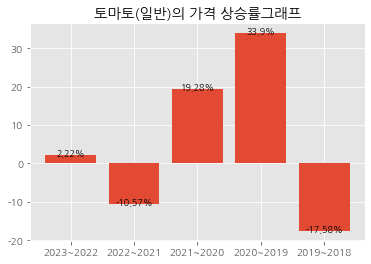

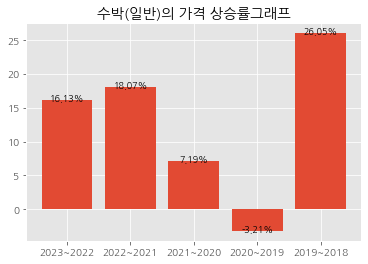

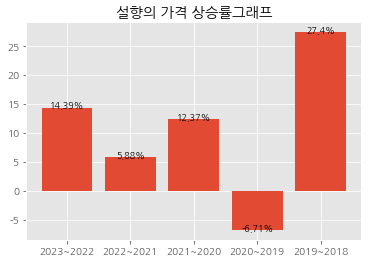

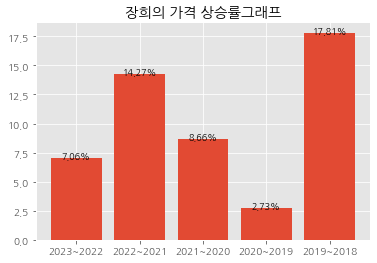

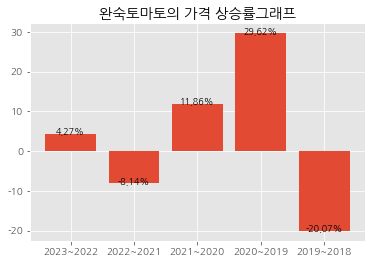

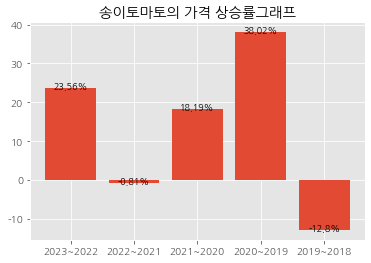

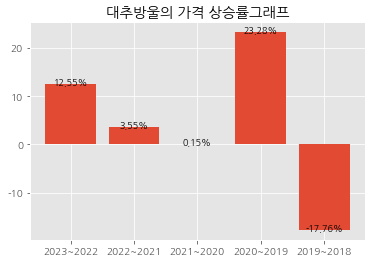

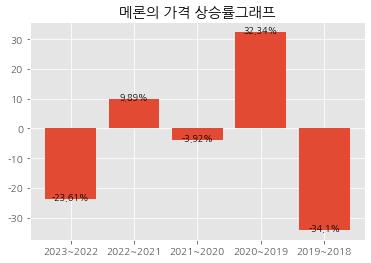

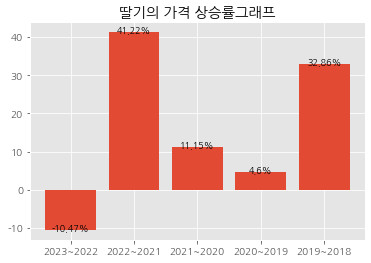

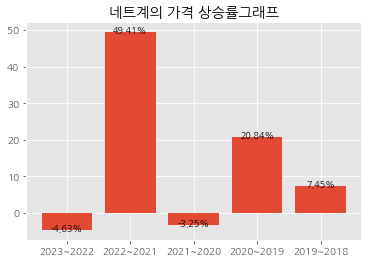

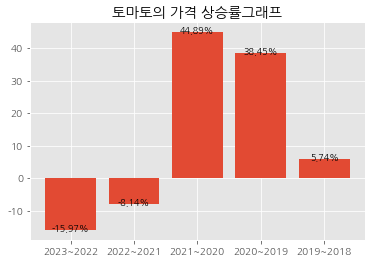

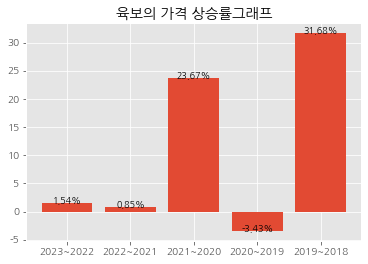

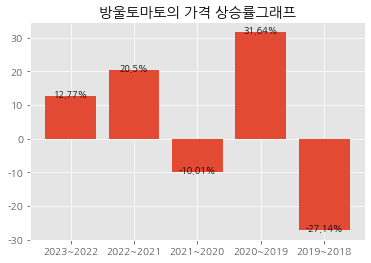

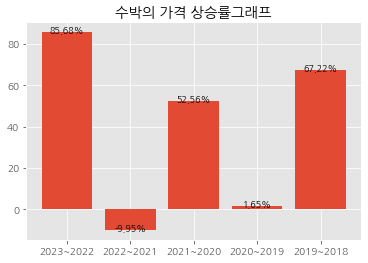

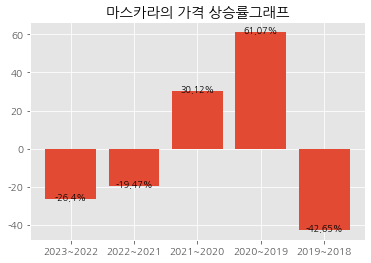

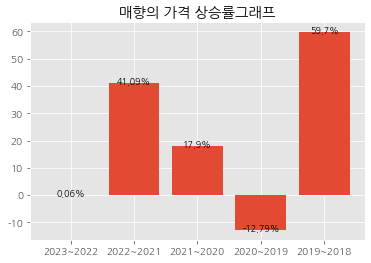

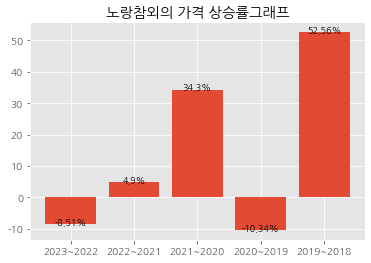

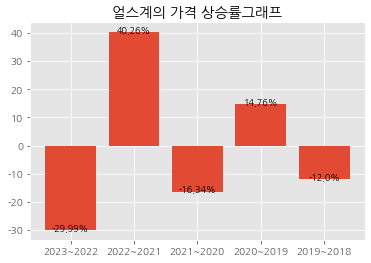

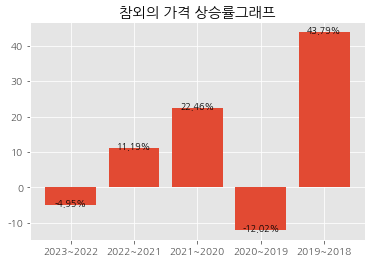

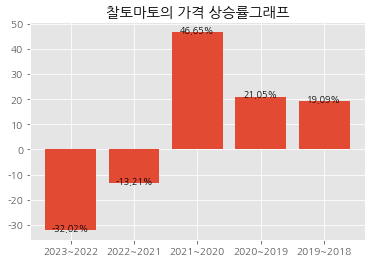

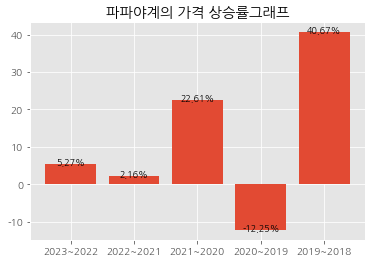

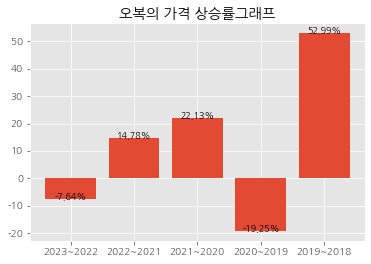

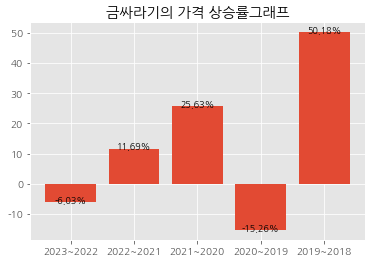

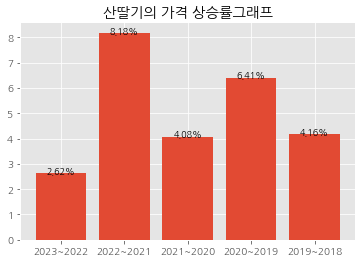

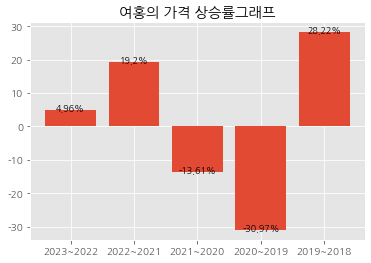

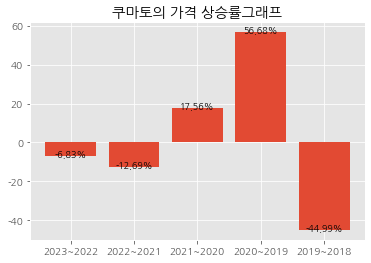

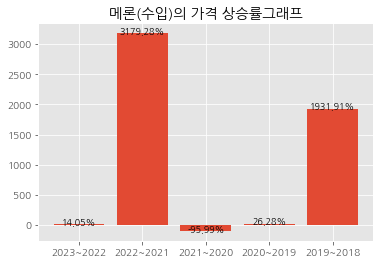

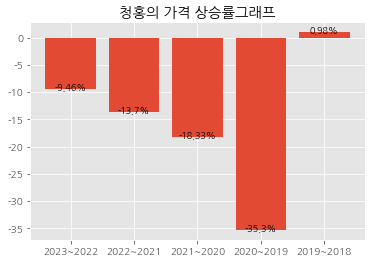

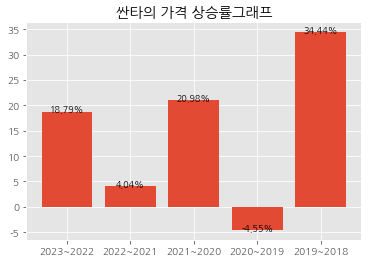

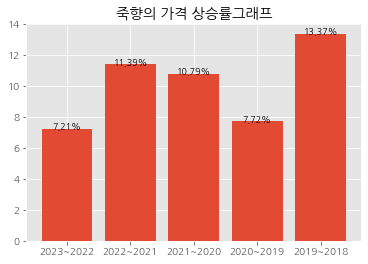

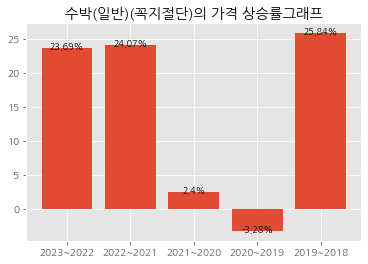

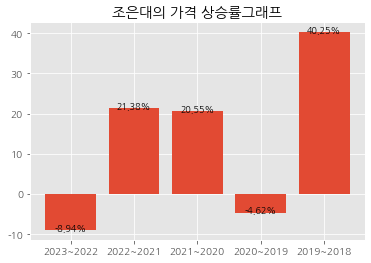

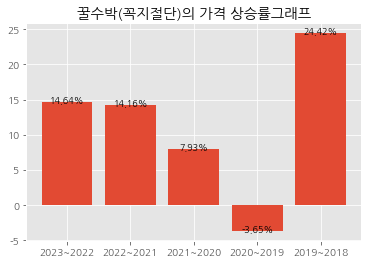

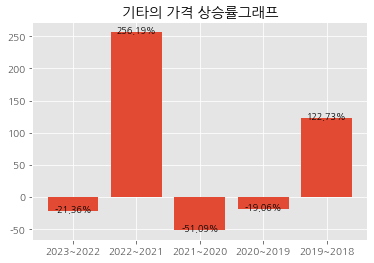

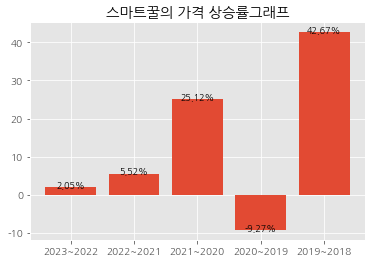

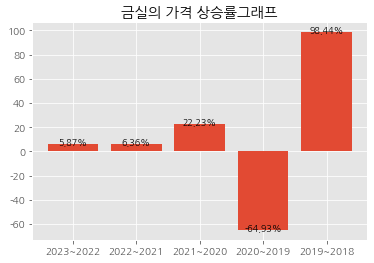

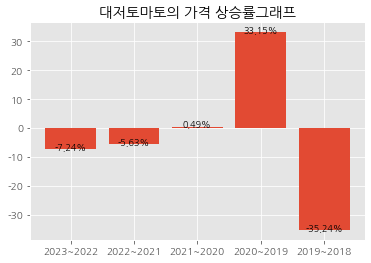

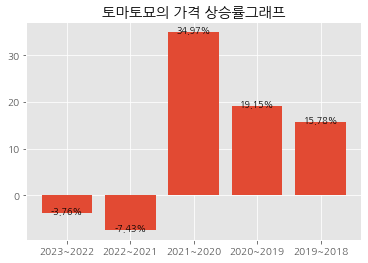

In [59]:
date_x = []
test_year=['2023']+test_year
for i in range(len(test_year)-1):
  date_x.append(test_year[i]+'~'+test_year[i+1])

#가격 상승률 그래프
for i in range(len(x)):
  plt.style.use('ggplot')
  font_name = fm.FontProperties(fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', size=10).get_name()
  plt.rc('font', family=font_name)
  plt.rc('axes', unicode_minus=False)
  plt.bar(date_x,y[i])
  
  for j, v in enumerate(date_x):
    plt.text(v, y[i][j], str(y[i][j])+'%',                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='baseline')  
  plt.title("%s의 가격 상승률그래프" %x[i])
  plt.show()


In [69]:
#수입산 메론의 경우 가격 변동폭이 너무 크기때문에 제외
#기타 또한 어떤 물품인지 모르므로 제외
percent[26] = 0.0
price[26] = 0
percent[33] = 0.0
print('2023 {} 상승률이 가장 높게 예측되는 과일은 {}이고,  상승률은 {}입니다.'.format(month+'월', x[percent.index(max(percent))],str(max(percent))+'%'))
print('2023 {} 가격이 가장 높게 예측되는 과일은 {}이고, 예상 가격은 {}원 입니다.'.format(month+'월',x[price.index(max(price))],round(max(price),2)))

2023 03월 상승률이 가장 높게 예측되는 과일은 금실이고,  상승률은 98.44%입니다.
2023 03월 가격이 가장 높게 예측되는 과일은 산딸기이고, 예상 가격은 37298.96원 입니다.
